# Using EvoAug DeepSTARR model to test for distance dependent cooperativity between motifs
**Authorship:**
Adam Klie (last updated: *07/19/2023*)
***
**Description:**
This notebook uses a pretrained DeepSTARR model to show how to perform a distance dependent cooperativity analysis using EUGENe. We recapitulate panel b) of Figure 5 from the DeepSTARR paper: https://www.nature.com/articles/s41588-022-01048-5
***

In [1]:
# Imports
import os
import torch
import numpy as np
from evoaug import evoaug
from evoaug_analysis import utils, model_zoo

# Load the model
The DeepSTARR model take ins length 249 nt sequences and the output is 2 scalar values representing the activity of developmental enhancers and housekeeping enhancers measured experimentally using STARR-seq.

In [3]:
# Load the DeepSTARR model that was trained in the evo_aug paper
ckpt_path = "/cellar/users/aklie/projects/ML4GLand/models/DeepSTARR/evoaug/attr_analysis/DeepSTARR_baseline_1.ckpt"
deepstarr = model_zoo.DeepSTARR(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = evoaug.RobustModel(
    deepstarr, 
    criterion=loss, 
    optimizer=optimizer_dict, 
    augment_list=[]
)
# load model weights
standard_cnn = evoaug.load_model_from_checkpoint(standard_cnn, ckpt_path).eval()

Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file projects/ML4GLand/models/DeepSTARR/evoaug/attr_analysis/DeepSTARR_baseline_1.ckpt`


# Load motifs: ETS, SREBP, GATA, AP-1 and Dref
See Supplementary table 10 of the DeepSTARR paper for the motif IDs (parially listed below). We will perform a distance-cooperativity analysis the four combinations of motifs listed in the paper:

1. ETS and SREBP
2. GATA and GATA
3. AP-1 and GATA
4. Dref and Dref

| TF motif | PWM model                                          | Collection name |
|----------|----------------------------------------------------|-----------------|
| AP-1     | jaspar__MA0476.1                                   | jaspar          |
| GATA     | flyfactorsurvey__srp_SANGER_5_FBgn0003507           | flyfactorsurvey |
| twist    | flyfactorsurvey__twi_da_SANGER_5_FBgn0000413        | flyfactorsurvey |
| Trl      | flyfactorsurvey__Trl_FlyReg_FBgn0013263             | flyfactorsurvey |
| SREBP    | flyfactorsurvey__HLH106_SANGER_10_FBgn0015234       | flyfactorsurvey |
| ETS      | flyfactorsurvey__Ets97D_SANGER_10_FBgn0004510       | flyfactorsurvey |
| Dref     | homer__AVYTATCGATAD_DREF                           | homer           |
| Ohler1   | homer__MYGGTCACACTG_Unknown1                       | homer           |
| Ohler6   | homer__AAAAATACCRMA_Unknown4                | homer           |

In [4]:
# We can use motifdata for the jaspar and homer motif databases
import motifdata as md

In [5]:
# From jaspar
ap1_motif = md.load_jaspar(motif_accs=["MA0476.1"])["MA0476.1"]
ap1_consensus = ap1_motif.consensus

# From flybase, had to do manual
gata_consensus = "TGATAAGG"
ets_consensus = "ACCGGAAGT"
srebp_consensus = "ATCACGCGAC"

# From homer
dref_motif = md.read_homer("/cellar/users/aklie/opt/homer/motifs/insects/dref.motif")["AVYTATCGATAD"]
dref_consensus = dref_motif.consensus

# Generate a name to consensus dictionary
name_to_consensus = {
    "AP-1": ap1_consensus,
    "GATA": gata_consensus,
    "ETS": ets_consensus,
    "SREBP": srebp_consensus,
    "DREF": dref_consensus
}

# Print out the consensus sequences
print(f"AP-1: {ap1_consensus}")
print(f"GATA: {gata_consensus}")
print(f"ETS: {ets_consensus}")
print(f"SREBP: {srebp_consensus}")
print(f"DREF: {dref_consensus}")

AP-1: TGTGACTCATT
GATA: TGATAAGG
ETS: ACCGGAAGT
SREBP: ATCACGCGAC
DREF: AACTATCGATAG


# Mode 1: ETS/SREBP -- synergize exclusively at close distances (<25 bp)

In [6]:
import xarray as xr
import seqpro as sp
from eugene import interpret
from eugene import plot as pl

/cellar/users/aklie/projects/ML4GLand/SeqExplainer/seqexplainer/attributions/_references.py:182: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if bg is "uniform":
/cellar/users/aklie/projects/ML4GLand/SeqExplainer/seqexplainer/attributions/_references.py:186: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif bg is "batch":
/cellar/users/aklie/projects/ML4GLand/SeqExplainer/seqexplainer/attributions/_references.py:190: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif bg is "seq":
Matplotlib is building the font cache; this may take a moment.


In [7]:
# Analysis params
seq_number = 60
seq_len = 249
comparisons = [
    ("ETS", "SREBP"),
    ("GATA", "GATA"),
    ("AP-1", "GATA"),
    ("DREF", "DREF")
]

In [8]:
random_backbones = sp.random_seqs((seq_number, seq_len), alphabet=sp.alphabets.DNA, seed=42)
sdata = xr.Dataset({"seq": (["_sequence", "_length"], random_backbones)})

In [10]:
pl.distance_cooperativity_gia_plot?

Signature:
pl.distance_cooperativity_gia_plot(
    sdata,
    results_var: str = 'cooperativity',
    distance_var: str = 'distance',
    col_names: Optional[List[str]] = None,
    cols_to_plot: Optional[List[str]] = None,
    motif_a_name: str = '',
    motif_b_name: str = '',
) -> None
Docstring:
Plot the median predicted cooperativity as a function of motif pair distance.

Parameters
----------
sdata : np.ndarray
    The input data array.
results_var : str, optional
    The name of the variable containing the cooperativity results, by default "cooperativity".
distance_var : str, optional
    The name of the variable containing the motif pair distances, by default "distance".
col_names : List[str], optional
    The names of the columns in the input data array, by default None.
cols_to_plot : List[str], optional
    The names of the columns to plot, by default None.
motif_a_name : str, optional
    The name of the first motif, by default "".
motif_b_name : str, optional
    The name o

In [11]:
sdata

<xarray.Dataset>
Dimensions:                  (_sequence: 60, _length: 249,
                              _ETS_SREBP_distance: 220, _predictions: 2,
                              _GATA_GATA_distance: 225,
                              _AP-1_GATA_distance: 222, _DREF_DREF_distance: 213)
Dimensions without coordinates: _sequence, _length, _ETS_SREBP_distance,
                                _predictions, _GATA_GATA_distance,
                                _AP-1_GATA_distance, _DREF_DREF_distance
Data variables:
    seq                      (_sequence, _length) |S1 b'A' b'T' ... b'C' b'G'
    ETS_SREBP_distance       (_ETS_SREBP_distance) <U4 '-119' '-118' ... '+120'
    ETS_SREBP_cooperativity  (_ETS_SREBP_distance, _sequence, _predictions) float32 ...
    GATA_GATA_distance       (_GATA_GATA_distance) <U4 '-120' '-119' ... '+121'
    GATA_GATA_cooperativity  (_GATA_GATA_distance, _sequence, _predictions) float32 ...
    AP-1_GATA_distance       (_AP-1_GATA_distance) <U4 '-118' '-117' ... '+123'
    AP-1_GATA_cooperativity  (_AP-1_GATA_distance, _sequence, _predictions) float32 ...
    DREF_DREF_distance       (_DREF_DREF_distance) <U4 '-118' '-117' ... '+119'
    DREF_DREF_cooperativity  (_DREF_DREF_distance, _sequence, _predictions) float32 ...

Running ('ETS', 'SREBP')
Getting background scores
Getting motif A scores


Calculating fold changes for each provided distance between MotifA and MotifB:   0%|          | 0/220 [00:00<?…

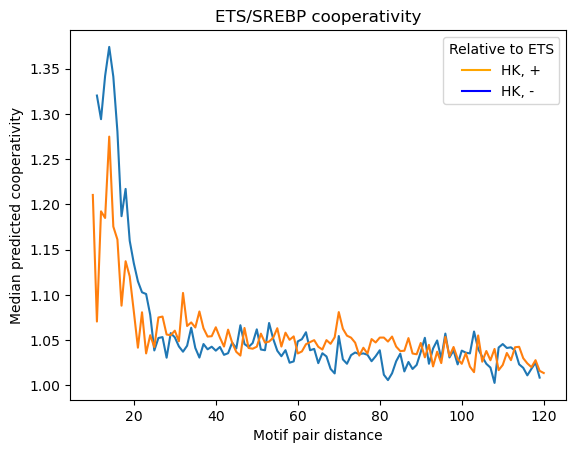

Running ('GATA', 'GATA')
Getting background scores
Getting motif A scores


Calculating fold changes for each provided distance between MotifA and MotifB:   0%|          | 0/225 [00:00<?…

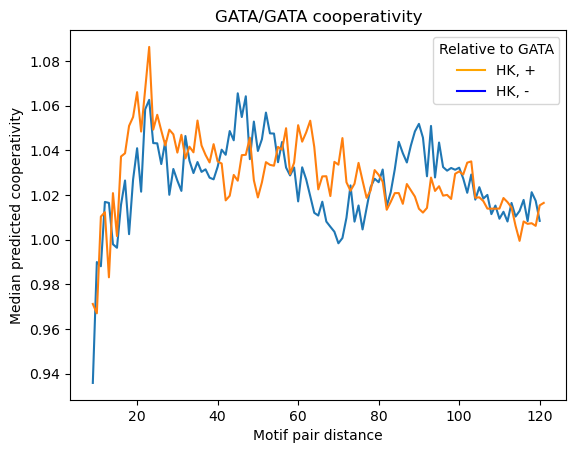

Running ('AP-1', 'GATA')
Getting background scores
Getting motif A scores


Calculating fold changes for each provided distance between MotifA and MotifB:   0%|          | 0/222 [00:00<?…

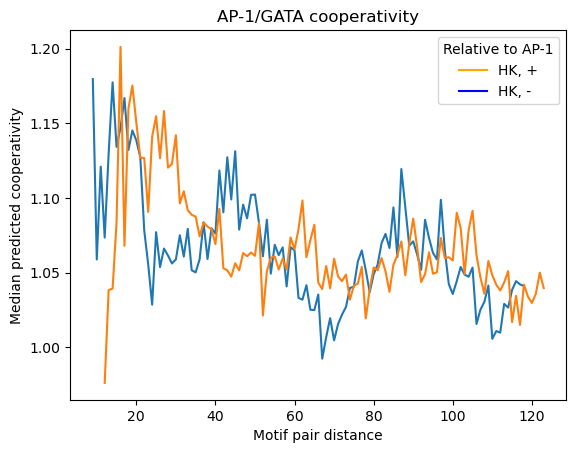

Running ('DREF', 'DREF')
Getting background scores
Getting motif A scores


Calculating fold changes for each provided distance between MotifA and MotifB:   0%|          | 0/213 [00:00<?…

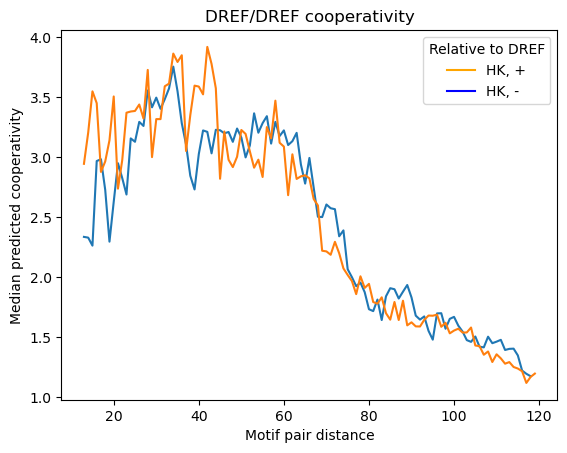

In [12]:
for comparison in comparisons:
    print(f"Running {comparison}")
    motif_a_name, motif_b_name = comparison

    # Run the GIA
    interpret.motif_distance_dependence_gia(
        model=standard_cnn,
        sdata=sdata,
        feature_A=name_to_consensus[motif_a_name],
        feature_B=name_to_consensus[motif_b_name],
        tile_step=1,
        style="deAlmeida22",
        seq_var="seq",
        results_var=f"{motif_a_name}_{motif_b_name}_cooperativity",
        distance_var=f"{motif_a_name}_{motif_b_name}_distance",
        device="cuda",
        batch_size=128
    )

    # Plot the results
    pl.distance_cooperativity_gia_plot(
        sdata,
        results_var=f"{motif_a_name}_{motif_b_name}_cooperativity",
        distance_var=f"{motif_a_name}_{motif_b_name}_distance",
        col_names=["Dev", "HK"],
        cols_to_plot=["HK"],
        motif_a_name=motif_a_name,
        motif_b_name=motif_b_name
    )

# DONE!

---

# Scratch